In [133]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy as sp
import urllib.parse
import re

## Data Retrieval

We can see two base url used to retrive data, the ```URL_FORM_BASE``` for the form and ```URL_DATA_BASE``` for the data (the table which contains the actual information).

In [134]:
URL_FORM_BASE = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter"
URL_DATA_BASE = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html"

By first inspecting the source code of the page we can see that the form has some hidden field, they indicate to the backend what kind of data to retrieve. We can thus form a dictionary of "default parameters".

In [135]:
FORM_PARAM_DEFAULT = {
    "ww_v_list" : 1,
    "ww_i_reportmodel": "133685247",
    #"ww_c_langue": 'en', # We work with the frenc version to match the questions
}

We then take interest in the form itself. We can see that we have 5 different fields each with a specific name attribute. (When the form is "posted" the name attribute is used to generate the url). We can thus retrieve all the options for each field relying on his name attribute.

We will only work with the HTML data so we directly take the parameters from the source code and don't bother to parse the HMTL page to retrieve it (for HMTL use a value of 133685270 for the ww_i_reportModelXsl attribute).

In [136]:
def request2soup(url, params):
    r = requests.get(url, params=params)
    assert r.status_code == 200
    return BeautifulSoup(r.text, "lxml")

def get_select_options(soup, name_attr):
    data = soup.select('select[name={}]'.format(name_attr))[0] #We assume that we have only one field with a specific name
    options = {option['value']: option.text for option in data.find_all('option', value=True, selected=False) if  option.text != ''}
    return options

def get_fields_options(soup, fields):
    form_options = {}
    for key, value in fields.items():
        form_options[value] = get_select_options(soup, value)
    
    return form_options

FORM_FIELDS = {
    # Label : Name Attribute
    'Unité académique': 'ww_x_UNITE_ACAD',
    'Période académique': 'ww_x_PERIODE_ACAD',
    'Période pédagogique': 'ww_x_PERIODE_PEDAGO',
    'Type de semestre': 'ww_x_HIVERETE',
}

soup_index = request2soup(URL_FORM_BASE, FORM_PARAM_DEFAULT)

FORM_FIELDS_OPTIONS = get_fields_options(soup_index, FORM_FIELDS)

In [137]:
FORM_FIELDS_OPTIONS

{'ww_x_HIVERETE': {'2936286': "Semestre d'automne",
  '2936295': 'Semestre de printemps'},
 'ww_x_PERIODE_ACAD': {'123455150': '2011-2012',
  '123456101': '2012-2013',
  '213637754': '2013-2014',
  '213637922': '2014-2015',
  '213638028': '2015-2016',
  '355925344': '2016-2017',
  '39486325': '2010-2011',
  '978181': '2007-2008',
  '978187': '2008-2009',
  '978195': '2009-2010'},
 'ww_x_PERIODE_PEDAGO': {'2063602308': 'Mise à niveau',
  '2226616': 'Stage automne 4ème année',
  '2226626': 'Stage printemps 4ème année',
  '2226768': 'Bachelor semestre 5b',
  '2226785': 'Bachelor semestre 6b',
  '2227132': 'Stage printemps master',
  '2230106': 'Master semestre 1',
  '2230128': 'Master semestre 3',
  '2230140': 'Master semestre 4',
  '2335667': 'Mineur semestre 1',
  '2335676': 'Mineur semestre 2',
  '249108': 'Bachelor semestre 1',
  '249114': 'Bachelor semestre 2',
  '249127': 'Projet Master automne',
  '2754553': 'Semestre printemps',
  '3781783': 'Projet Master printemps',
  '942120': 

By submiting the form, we get a table filled with links at the bottom of the form back. Of course ISA does not want to play it simple and rely instead of the href attribute to javascript for the link behaviour. A clicked link call the js function "loadReport" which generate the "data url" based on the ww_x_GPS attribute. 

First we define two utilities function to generate for us the complete url based on the given parameters.

In [138]:
# Get Url for the form page (the one with the links)
def get_form_url(params):
    return URL_FORM_BASE + "?" + urllib.parse.urlencode(dict(params, **FORM_PARAM_DEFAULT))

# Get Url for the data page (the one with the table of students information)
def get_data_url(params, GPS=-1, type=133685270):
    p = {'ww_x_GPS': GPS, 'ww_i_reportModelXsl': type}
    return URL_DATA_BASE + "?" + urllib.parse.urlencode(dict(dict(params, **FORM_PARAM_DEFAULT), **p))

Instead of parsing the form page to retrieve the ww_x_GPS attribute, we generate directly the data url based on the form options discovered above.

In [139]:
# Returns a dataframe containing all the student information from 2007 to 2016 for the given pedagogic period
def get_data(period_peda, columns):
    data_list = []
    for peda in period_peda:
        for period in FORM_FIELDS_OPTIONS['ww_x_PERIODE_ACAD']:
            params = {
                'ww_x_UNITE_ACAD': 249847, # hard coded: only interested in the computer science faculty
                'ww_x_PERIODE_ACAD': period,
                'ww_x_PERIODE_PEDAGO': peda,
                'ww_x_HIVERETE': '',
            }  
            
            try: 
                # By specifying ww_x_UNITE_ACAD, ww_x_PERIODE_ACAD, ww_x_PERIODE_PEDAGO we are sur 
                # that only one table will be present on the page. Indeed there was only one BA1 class in year
                # for the computer science faculty
                data = pd.read_html(get_data_url(params), header=1)[0]
                df = data.copy()[columns] # Only keep interesting columns
                df['semester'] = period_peda[peda] # Add semester information
                df['period'] = FORM_FIELDS_OPTIONS['ww_x_PERIODE_ACAD'][period] # Add period information
                data_list.append(df)
            except:
                # read_html might throw an error if there is no table in the page
                print("No Data : " +  period_peda[peda] + " " + FORM_FIELDS_OPTIONS['ww_x_PERIODE_ACAD'][period])
        
    d = pd.concat(data_list) 
    return d

--------------

# Q1 : Bachelor Data Analysis

In [140]:
bachelor = {  
    '249108': 'Bachelor semestre 1',
    '249114': 'Bachelor semestre 2',
    '942155': 'Bachelor semestre 3',
    '942163': 'Bachelor semestre 4',
    '942120': 'Bachelor semestre 5',
    '942175': 'Bachelor semestre 6',
    #'2226768': 'Bachelor semestre 5b', # No data, no need to retrieve page
    #'2226785': 'Bachelor semestre 6b', # No data, no need to retrieve page
}
columns = ['No Sciper', 'Statut', 'Civilité']

# Retrieve the data
d = get_data(bachelor, columns)
d['No Sciper'] = d['No Sciper'].apply(str)
bachelor = d.copy()

Now that we have the data in a pandas dataframe we can start working on it.

# TODO

### Assumption
 * how we computed the time elapsed esp. the + .5 in the formula
 * why there are already values for year 2017 (student abroad for 3rd year)
 * How did a guy spent 7 years for his bachelor (one year break)

In [141]:
# Return if Dataframe has both ba1 ba6 entries
first_and_last = lambda semesters: "Bachelor semestre 1" in semesters and "Bachelor semestre 6" in semesters
# Return if the semester is an autumn semester or not
is_autumn = lambda sem: int(sem[-1:]) % 2 == 1
# Return if we should keed the row (based on the is_autumn result)
idx_to_keep = lambda sem: 0 if sem else 1

In [142]:
grouped = d.groupby(['No Sciper'])
# Only keep the student for which we have at least information about BA1 and BA6
filtered = grouped.filter(lambda x: len(x.values) >= 2 and first_and_last(x.values)).copy()
filtered.head()

,No Sciper,Statut,Civilité,semester,period
0,228219,Présent,Monsieur,Bachelor semestre 3,2014-2015
2,219665,Présent,Madame,Bachelor semestre 3,2014-2015
3,227120,Présent,Monsieur,Bachelor semestre 3,2014-2015
4,214939,Présent,Monsieur,Bachelor semestre 3,2014-2015
5,236802,Présent,Monsieur,Bachelor semestre 3,2014-2015


In [143]:
# Add extracted information to ease our analysis
filtered['is_autumn'] = filtered['semester'].apply(lambda x: is_autumn(x))
filtered['date'] = filtered.apply(lambda x: int(x['period'].split("-")[idx_to_keep(x['is_autumn'])]), axis=1)
filtered['date_help'] = filtered.apply(lambda x: float(x.date) + (.5 if x.is_autumn else 0), axis=1)
filtered.head()

,No Sciper,Statut,Civilité,semester,period,is_autumn,date,date_help
0,228219,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5
2,219665,Présent,Madame,Bachelor semestre 3,2014-2015,True,2014,2014.5
3,227120,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5
4,214939,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5
5,236802,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5


In [144]:
grpd = filtered.groupby(['No Sciper'])
duration = grpd.apply(lambda x: max(x.date_help) - min(x.date_help) + .5)
# Finally add total time spend in bachelor
filtered['time_elapsed'] = filtered['No Sciper'].apply(lambda sciper: duration[sciper])
filtered.head()

,No Sciper,Statut,Civilité,semester,period,is_autumn,date,date_help,time_elapsed
0,228219,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5,3.0
2,219665,Présent,Madame,Bachelor semestre 3,2014-2015,True,2014,2014.5,4.5
3,227120,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5,3.0
4,214939,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5,3.5
5,236802,Présent,Monsieur,Bachelor semestre 3,2014-2015,True,2014,2014.5,3.0


In [145]:
# Strip down the dataframe to a more usefull representation
df = filtered.groupby(['No Sciper'])['Civilité', 'time_elapsed'].agg(lambda x:x.value_counts().index[0])
df.head()

,Civilité,time_elapsed
No Sciper,,
147008,Monsieur,3.0
169569,Monsieur,3.0
169731,Monsieur,4.0
169795,Monsieur,4.5
171195,Monsieur,3.0


### Duration distribution by sex

As we can see, most of the one who finish their bachelor finish it in three years.

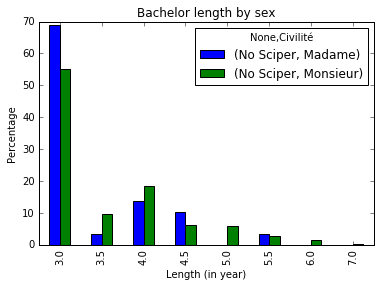

In [146]:
tmp = df.reset_index().groupby(['Civilité','time_elapsed']).count()
tmp = tmp.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
tmp = tmp.unstack(level=0)
graph = tmp.plot(kind='bar')
graph.set_xlabel('Length (in year)')
graph.set_ylabel('Percentage')
graph.set_title('Bachelor length by sex')

### Duration mean by sex

First we just look at the data using a simple describe. It seems that there is indeed a difference in the mean duration when looking at the sex of the student.

In [147]:
df.groupby(['Civilité']).describe()

time_elapsed
Civilité                    
Madame   count     29.000000
         mean       3.396552
         std        0.673203
         min        3.000000
         25%        3.000000
         50%        3.000000
         75%        4.000000
         max        5.500000
Monsieur count    368.000000
         mean       3.573370
         std        0.788229
         min        3.000000
         25%        3.000000
         50%        3.000000
         75%        4.000000
         max        7.000000

#### Hypothesis testing
We will now test if the difference between the two means is statistically signigicant.

In [148]:
M = df.groupby(['Civilité']).get_group('Monsieur')['time_elapsed']
F = df.groupby(['Civilité']).get_group('Madame')['time_elapsed']
print("Men Mean (in semester): {}".format(M.mean()*2))
print("Female Mean (in semester): {}".format(F.mean()*2))

Men Mean (in semester): 7.146739130434782
Female Mean (in semester): 6.793103448275862


We will use as our H0 hypothesis:
    
    
    The mean duration for male and female students at epfl in the computer science faculty is identical
    
By looking at the distribution plot above, we can see that the duration don't seem to follow a normal distribution. We will then use the Mann-Withney U-test which is a nonparametric test of the null hypothesis that two samples come from the same population against an alternative hypothesis, especially that a particular population tends to have larger values than the other.

In [149]:
from scipy import stats

statistic, p_value = stats.mannwhitneyu(M, F, alternative='two-sided')
print('P-value: {}'.format(p_value))

P-value: 0.20004233700145535


We find a p-value greater than 0.05 meaning that at significance level of 5%, their is no difference is the distribution of the time spend in bachelor for men and women. 

It is important to note that this test might be skewd. The Mann-Whitney U test assumes independence of observations but in reality each duration is not completely independant of the other. Indeed an exam session might be toughter than the previous one increasing the change to add a semester to each one of the student passing the exam during the tougher session.

# Q2 : Master Data Analysis

In [152]:
master = {  
    #'953137':  'Stage automne 3ème année', # No Data
    #'983606':  'Stage printemps 3ème année', # No Data
    #'2226616': 'Stage automne 4ème année', # No Data
    #'2226626': 'Stage printemps 4ème année', # No Data
    #'2227132': 'Stage printemps master', # No Data
    '2230106': 'Master semestre 1',
    '942192':  'Master semestre 2',
    '2230128': 'Master semestre 3',
    #'2230140': 'Master semestre 4', # No Data
    #'2335667': 'Mineur semestre 1', # No Data
    #'2335676': 'Mineur semestre 2', # No Data
    #'2754553': 'Semestre printemps', # No Data
    #'953159':  'Semestre automne', # No Data
    '249127':  'Projet Master automne',
    '3781783': 'Projet Master printemps',
}


columns = ['No Sciper', 'Statut', 'Civilité', 'Mineur', 'Spécialisation',]

# Retrieve the data
d = get_data(master, columns)
d['No Sciper'] = d['No Sciper'].apply(str)
master = d.copy()

No Data : Projet Master printemps 2014-2015
No Data : Projet Master printemps 2016-2017
No Data : Projet Master printemps 2015-2016


In [155]:
master.head()

,No Sciper,Statut,Civilité,Mineur,Spécialisation,semester,period
0,166075,Présent,Monsieur,NaN,NaN,Master semestre 2,2014-2015
1,245182,Présent,Monsieur,NaN,NaN,Master semestre 2,2014-2015
2,194182,Présent,Monsieur,NaN,Foundations of Software,Master semestre 2,2014-2015
3,225434,Présent,Monsieur,"Mineur en Management, technologie et entrepren...",NaN,Master semestre 2,2014-2015
4,244650,Présent,Monsieur,NaN,NaN,Master semestre 2,2014-2015


# TODO

### Assumption
 * Assumes that if a student had once a minor, he has to do his master in at least three semester
 * Don't verify that a student that has a minor and a stage do 4 semester with courses
 * If student has neither a entry for PDM or a mention of a stage semester we add 6 months to the duration
 * If student has only a stage semester add 6 months for the PDM
 * If student has only PDM, don't add anything

In [156]:
# Return if student has finished his master
def first_and_last(rows):
    minor = sum([np.nan in [x[3]] for x in rows]) > 0
    spe = sum([np.nan in [x[4]] for x in rows]) > 0
    
    if minor or spe:
        return "Master semestre 1" in rows and "Master semestre 3" in rows

    return "Master semestre 1" in rows and "Master semestre 2" in rows
    
# Return if the semester is an autumn semester or not
def is_autumn(sem):
    if 'automne' in sem:
        return True
    elif 'printemps' in sem:
        return False
    else:
        return int(sem[-1:]) % 2 == 1  
    
# Return if we should keed the row (based on the is_autumn result)
idx_to_keep = lambda sem: 0 if sem else 1

def add_semester(rows):
    projet = rows['semester'].str.contains('Projet').max()
    stage = rows['Statut'].str.contains('Stage').max()
    return (not projet and stage) or (not projet and not stage)

def get_spe(rows):
    spe = rows[rows['semester'] == 'Master semestre 3']['Spécialisation'].value_counts()
    if len(spe):
        assert len(spe) == 1
        return spe.index[0]
    return None

def get_minor(rows):
    spe = rows[rows['semester'] == 'Master semestre 3']['Mineur'].value_counts()
    if len(spe):
        assert len(spe) == 1
        return spe.index[0]
    return None

In [157]:
grouped = d.groupby(['No Sciper'])
# Only keep the student for which we have information about at least MA1 and MA2
filtered = grouped.filter(lambda x: len(x.values) >= 2 and first_and_last(x.values)).copy()
filtered.sort_values('No Sciper').head()

,No Sciper,Statut,Civilité,Mineur,Spécialisation,semester,period
14,146330,Présent,Monsieur,NaN,NaN,Master semestre 1,2007-2008
11,146330,Présent,Monsieur,NaN,NaN,Master semestre 3,2008-2009
17,146330,Présent,Monsieur,NaN,NaN,Master semestre 2,2007-2008
1,146742,Présent,Monsieur,NaN,"Signals, Images and Interfaces",Projet Master automne,2010-2011
37,146742,Présent,Monsieur,NaN,"Signals, Images and Interfaces",Master semestre 1,2008-2009


In [122]:
# Add extracted information to ease our analysis
filtered['is_autumn'] = filtered['semester'].apply(lambda x: is_autumn(x))
filtered['date'] = filtered.apply(lambda x: int(x['period'].split("-")[idx_to_keep(x['is_autumn'])]), axis=1)
filtered['date_help'] = filtered.apply(lambda x: float(x.date) + (.5 if x.is_autumn else 0), axis=1)
filtered.sort_values('No Sciper').head()

,No Sciper,Statut,Civilité,Mineur,Spécialisation,semester,period,is_autumn,date,date_help
14,146330,Présent,Monsieur,NaN,NaN,Master semestre 1,2007-2008,True,2007,2007.5
11,146330,Présent,Monsieur,NaN,NaN,Master semestre 3,2008-2009,True,2008,2008.5
17,146330,Présent,Monsieur,NaN,NaN,Master semestre 2,2007-2008,False,2008,2008.0
1,146742,Présent,Monsieur,NaN,"Signals, Images and Interfaces",Projet Master automne,2010-2011,True,2010,2010.5
37,146742,Présent,Monsieur,NaN,"Signals, Images and Interfaces",Master semestre 1,2008-2009,True,2008,2008.5


In [121]:
grpd = filtered.groupby(['No Sciper', 'Civilité'])
duration = grpd.apply(lambda x: max(x.date_help) - min(x.date_help) + .5)
add = grpd.apply(lambda x: add_semester(x)).astype('category')
minor = grpd.apply(lambda x: get_minor(x)).astype('category')
spe = grpd.apply(lambda x: get_spe(x)).astype('category')

print(len(add))
df = pd.concat({'duration': duration, 'add_semester':add, 'spe':spe, 'minor':minor }, axis=1)
df.head()

563


,,add_semester,duration,minor,spe
No Sciper,Civilité,,,,
146330,Monsieur,True,1.5,NaN,NaN
146742,Monsieur,False,4.5,NaN,"Signals, Images and Interfaces"
147008,Monsieur,True,2.0,NaN,NaN
152232,Monsieur,True,1.5,"Mineur en Management, technologie et entrepren...",NaN
153066,Monsieur,True,3.0,NaN,Internet computing


In [131]:
df['time_elapsed'] = df.apply(lambda x: x['duration'] + 0.5 if x['add_semester'] else x['duration'], axis=1)
df.head()

,,add_semester,duration,minor,spe,time_elapsed
No Sciper,Civilité,,,,,
146330,Monsieur,True,1.5,NaN,NaN,2.0
146742,Monsieur,False,4.5,NaN,"Signals, Images and Interfaces",4.5
147008,Monsieur,True,2.0,NaN,NaN,2.5
152232,Monsieur,True,1.5,"Mineur en Management, technologie et entrepren...",NaN,2.0
153066,Monsieur,True,3.0,NaN,Internet computing,3.5


### Average duration in master in computer science at EPFL

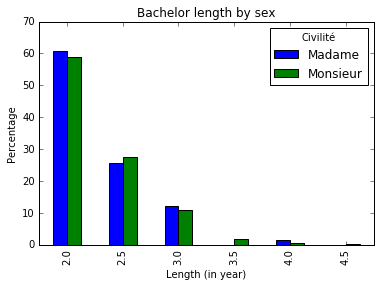

In [92]:
tmp = df.reset_index().groupby(['Civilité','time_elapsed'])['No Sciper'].count()
tmp = tmp.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
tmp = tmp.unstack(level=0)
graph = tmp.plot(kind='bar')
graph.set_xlabel('Length (in year)')
graph.set_ylabel('Percentage')
graph.set_title('Master length by sex')

In [95]:
avg_master = df['time_elapsed'].mean()
print('Average duration for masters students at EPFL: {} semesters'.format(avg_master*2))

Average duration for masters students at EPFL: 4.579040852575488 semesters


It is important to take into account that master students doing a minor or specialization are skewing the average to a higher value, we can thus look at the mean for student doing minor/specialization and students who don't.

In [108]:
students_l = df[~df['minor'].isnull() | ~df['spe'].isnull()]
students_s = df[df['minor'].isnull() & df['spe'].isnull()]
avg_master_s = students_s['time_elapsed'].mean()
avg_master_l = students_l['time_elapsed'].mean()
print("Number of students with a minor/spe: {} ({}%)".format(len(students_l), len(students_l)*100.0 / len(df) ))
print("  Avergage stay: {} semesters".format(avg_master_l*2))
print("Number of students without a minor/spe: {} ({}%)".format(len(students_s), len(students_s)*100.0 / len(df)))
print("  Avergage stay: {} semesters".format(avg_master_s*2))

Number of students with a minor/spe: 288 (51.15452930728242%)
  Avergage stay: 4.791666666666667 semesters
Number of students without a minor/spe: 275 (48.84547069271758%)
  Avergage stay: 4.356363636363636 semesters


### Average duration per specialisation



In [132]:
df[['spe', 'time_elapsed']].groupby('spe').mean()

,time_elapsed
spe,
Biocomputing,2.666667
Computer Engineering - SP,2.305556
Computer Science Theory,2.000000
Data Analytics,2.000000
Foundations of Software,2.448276
Information Security - SP,2.083333
Internet Information Systems,2.000000
Internet computing,2.380952
Service science,2.166667


# Q3 : Bonus